Modelling of regret when making sampling decisions as a first take on reaching LLM call optimality
with respect to exploration versus evaluation choices.

In [4]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import itertools

In [5]:
prompt1_true_perf = 0.9
prompt2_true_perf = 0.8
prompt3_true_perf = 0.5

### Eval distributions

The distribution we sample an eval from (for every prompt) is a Bernoulli since a singleevaluation 
is either successful or not.

#### Example scenario:

We have sampled a few evals for each prompt. What are the rational beliefs on the true performance
for each prompt?

In [6]:
prompt_1_evals_n = 5
prompt_2_evals_n = 5
prompt_3_evals_n = 5

np.random.seed(0)
prompt_1_evals = stats.bernoulli.rvs(prompt1_true_perf, size=prompt_1_evals_n)
prompt_2_evals = stats.bernoulli.rvs(prompt2_true_perf, size=prompt_2_evals_n)
prompt_3_evals = stats.bernoulli.rvs(prompt3_true_perf, size=prompt_3_evals_n)

#### Posteriors

Given Bayes theorem (and a for now assumed uniform prior) we can estimate the posterior for the mean
of each Bernoulli as a Beta distribution.

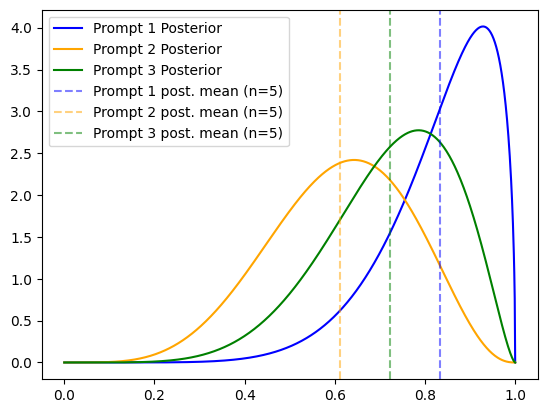

In [7]:
def beta_posterior(trials, prior_a=2.5, prior_b=1.5):
    n = len(trials)
    k = trials.sum()
    return stats.beta(a=prior_a + k, b=prior_b + n - k)


def plot_posteriors(prompt_1_evals, prompt_2_evals, prompt_3_evals):
    x = np.linspace(0, 1, 1000)
    y1 = beta_posterior(prompt_1_evals).pdf(x)
    y2 = beta_posterior(prompt_2_evals).pdf(x)
    y3 = beta_posterior(prompt_3_evals).pdf(x)

    prompt_1_posterior_mean = beta_posterior(prompt_1_evals).mean()
    prompt_2_posterior_mean = beta_posterior(prompt_2_evals).mean()
    prompt_3_posterior_mean = beta_posterior(prompt_3_evals).mean()

    plt.plot(x, y1, label="Prompt 1 Posterior", color="blue")
    plt.plot(x, y2, label="Prompt 2 Posterior", color="orange")
    plt.plot(x, y3, label="Prompt 3 Posterior", color="green")

    plt.axvline(
        prompt_1_posterior_mean,
        color="blue",
        linestyle="--",
        label=f"Prompt 1 post. mean (n={len(prompt_1_evals)})",
        alpha=0.5,
    )
    plt.axvline(
        prompt_2_posterior_mean,
        color="orange",
        linestyle="--",
        label=f"Prompt 2 post. mean (n={len(prompt_2_evals)})",
        alpha=0.5,
    )
    plt.axvline(
        prompt_3_posterior_mean,
        color="green",
        linestyle="--",
        label=f"Prompt 3 post. mean (n={len(prompt_3_evals)})",
        alpha=0.5,
    )

    plt.legend()


plot_posteriors(prompt_1_evals, prompt_2_evals, prompt_3_evals)

In this specific example the estimation of the performance of the second prompt is higher than the one
for the first prompt. Since then choosing the second prompt as the basis for a new prompt leaves
performance on the table (assuming the mean of the performance of the new prompt is a function of the
performance of the used prompt).

This now presents an interesting trade-off. Without knowing the true performances of any prompt, can
we estimate the expected improvmenet of our decision making by adding an evaluation to any of the prompts?

-> classic multi-armed bandit task

### Distribution over the maximum performance

The information over the maximum performance is what we prob. want to maximise when doing adding
and evaluation.

Entropy: -1727.8326410359905


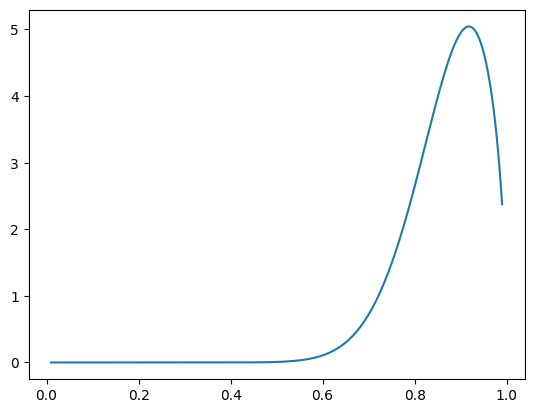

In [8]:
post1 = beta_posterior(prompt_1_evals)
post2 = beta_posterior(prompt_2_evals)
post3 = beta_posterior(prompt_3_evals)

x = np.linspace(0.01, 0.99, 1000)

prob = (
    post1.cdf(x) * post2.cdf(x) * post3.pdf(x)
    + post1.pdf(x) * post2.cdf(x) * post3.cdf(x)
    + post1.cdf(x) * post2.pdf(x) * post3.cdf(x)
)

plt.plot(x, prob)

entropy = np.sum(prob * -np.log2(prob))
print(f"Entropy: {entropy}")

## Regret

For a specific instance of prompt selection, lets denote the regret as the difference between the
true performance of the selected prompt and the true *best* performance.

For a configuration of evaluations, we are now interested in the expected regret.

0.8333333333333334
0.04075465367666243


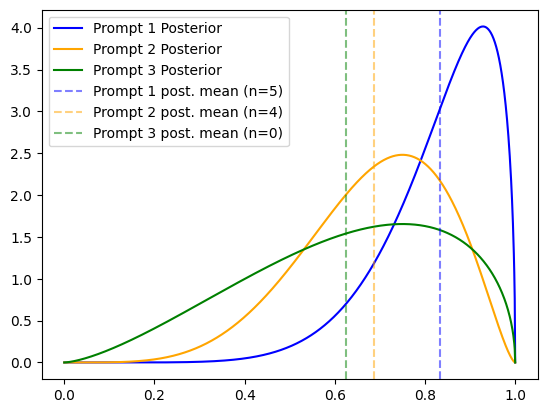

In [9]:
n_evals = [5, 4, 0]
true_performances = [0.99, 0.5, 0.99]

np.random.seed(0)
evals = [stats.bernoulli.rvs(p, size=n) for p, n in zip(true_performances, n_evals)]

posteriors = [beta_posterior(e) for e in evals]

plot_posteriors(*evals)


def expected_regret(evals, n_samples=1000000):
    posteriors = [beta_posterior(e) for e in evals]
    chosen_prompt = np.argmax([p.mean() for p in posteriors])

    samples = [p.rvs(size=n_samples) for p in posteriors]
    regrets = np.maximum.reduce(samples, axis=0) - samples[chosen_prompt]
    return np.mean(regrets)


print(posteriors[0].mean())
print(expected_regret(evals))

In [10]:
for prompt_idx in range(len(evals)):
    regrets = []
    for add_eval in [1, 0]:
        new_evals = evals.copy()
        new_evals[prompt_idx] = np.append(new_evals[prompt_idx], add_eval)
        regrets.append(expected_regret(new_evals))

    expected_new_expected_regret = np.sum(
        regrets
        * np.array([posteriors[prompt_idx].mean(), 1 - posteriors[prompt_idx].mean()])
    )
    print(
        f"Expected regret with adding eval to prompt {prompt_idx+1}: {expected_new_expected_regret}"
    )

Expected regret with adding eval to prompt 1: 0.04074138937969897
Expected regret with adding eval to prompt 2: 0.04073990216677459
Expected regret with adding eval to prompt 3: 0.0408308164454445
